In [556]:
import numpy as np
import matplotlib.pyplot as plt

### In this notebook, I built a Kalman filter from scratch. I want to estimate the position, velocity and acceleration of a Rocket moving in 1-dimensional space with a noisy (gaussian noise) GPS measurement of its position. The acceleration of the Rocket is constant.

# Simulation - Simulate a 1D Rocket with random motion

In [557]:
# Generate a random motion of the Rocket
acceleration = np.random.randint(-10, 10)
initial_v = np.random.randint(-10, 10)
initial_x = np.random.randint(-100, 100)

# Simulate the rocket movement with ordinary equations of motion
def rocket_movement(t):
    s = initial_x + initial_v * t + acceleration*(t**2)/2
    v = initial_v + acceleration*t
    a = acceleration
    return s, v, a

# Return the state vector of the rocket according to the number of time steps n
def actual_rocket_state(n):
    s, v, a = rocket_movement(n*h)
    return np.matrix([[s], [v], [a]])

# Kalman Filter

In [558]:
h = 0.5 # duration of one discrete timestep
duration = 30 # Total duration we are interested in 
sigma = 100 # standard deviation of measurement (gaussian distribution)

###### The state vector $x = (s, v, a)$ has the entries position, velocity and acceleration. It is important that x is the state vector of the system, and not the position. 
###### Differential equation that describes the dynamics in the continuous case: $\dot{x} = A_{cont}  x$, where $A_{cont} =  \begin{pmatrix}
 0& 1 & 0\\ 
 0& 0 & 1\\ 
 0&0  & 0
\end{pmatrix}$
###### solution: $x(t)=e^{A_{cont}t}x_0$ 
###### for one discrete timestep h: $x_n = e^{A_{cont}  h} x_{n-1}$ 
###### Find matrix representation using series expansion: $ A := e^{A_{cont}  h} = 1 + A_{cont} h + \frac{(A_{cont}h)^2}{2!}+ \dots$= $ \begin{pmatrix}
 1& h & \frac{h^2}{2}\\ 
 0& 1 & h\\ 
 0&0  & 1
\end{pmatrix}$

In [559]:
# Define A
A = np.array([[1, h,h**2 / 2],[0, 1, h],[0, 0, 1]])

##### The equation of the dynamics is:
##### $
 \mathbf{x}_n=A_{n-1} \mathbf{x}_{n-1} $,
 where A is the state dynamics matrix
 
 
$ \mathbf{y}_n=C_n \mathbf{x}_n+\mathbf{v}_n$,
where $y_n$ is the measurement output, $C_n$ is the measurement matrix, and $v_n$ is the measurement noise. 

In [560]:
# Define C
# We measure the position of the rocket using GPS. Thus, 
C = np.matrix([1, 0, 0]) # multiplied to a state vector, this gives the position only.

In [561]:
x_0 = np.array([[0],[0],[0]]) # Initial guess of the state

In [562]:
# Initial covariance matrix. It is the identity matrix
large = 1 # large is a large number, in this way P_0 describes maximum uncertainty about the state.
P_0 = np.matrix(np.eye(3)) * large

In [563]:
R = np.array([sigma**2]) # covariance matrix of noise, in our example it is just the variance, i.e sigma^2

# First step, propagate x and P to priori:

In [564]:
def propagate_dynamics(x_posteriori_n_minus_1):
    x_priori_n = A @ x_posteriori_n_minus_1 # Equation of the dynamics 
    return x_priori_n

##### How do we propagate P? 
##### $P_n$ is defined as the expectation value $E\left[\left(\mathbf{x}_n-\overline{\mathbf{x}}_n\right)\left(\mathbf{x}_n-\overline{\mathbf{x}}_n\right)^T\right]$, where $\overline{\mathbf{x}}_n = E[x_n]$.
##### Now calculate and simplify the expression $\left(\mathbf{x}_n-\overline{\mathbf{x}}_n\right)\left(\mathbf{x}_n-\overline{\mathbf{x}}_n\right)^T$ by using the equation of the dynamics. 
##### also note that $P_{n-1} = E \left [ \left(\mathbf{x}_{n-1}-\overline{\mathbf{x}}_{n-1}\right)\left(\mathbf{x}_{n-1}-\overline{\mathbf{x}}_{n-1}\right)^T  \right ]$. 
##### This leads to $P_n = A P_{n-1} A^T$

In [565]:
def propagate_P(P_posteriori_n_minus_1):
    P_priori_n = A @ P_posteriori_n_minus_1 @ np.transpose(A)
    return P_priori_n

# Second step, obtain measurement data y_n and propagate x and P to new posteriori:

In [566]:
def calculate_K(P_priori_n): # auxiliary function, K is the Kalman-filter-gain-matrix
    K_n = P_priori_n @ np.transpose(C) @ np.linalg.inv((R + C @ P_priori_n @ np.transpose(C)))
    return K_n

def update_x(x_priori_n, P_priori_n, y_n):
    K_n = calculate_K(P_priori_n)
    x_posteriori_n = x_priori_n + K_n @ (y_n - C @ x_priori_n)
    #print(x_posteriori_n)
    return x_posteriori_n

def update_P(P_priori_n):
    K_n = calculate_K(P_priori_n)
    P_posteriori_n = (np.eye(3) - K_n @ C) @ P_priori_n
    return P_posteriori_n

# Execution

In [567]:
# one full step in the Kalman filter:
def Kalman(y_n, x_posteriori_n_minus_1, P_posteriori_n_minus_1):
    x_priori_n = propagate_dynamics(x_posteriori_n_minus_1)
    P_priori_n = propagate_P(P_posteriori_n_minus_1)
    x_posteriori_n = update_x(x_priori_n, P_priori_n, y_n)
    P_posteriori_n = update_P(P_priori_n)
    return x_posteriori_n, P_posteriori_n    

In [568]:
# Repeat the Kalman filter for all time steps in the duration
estimated_state = []
measured_position = []
actual_state = []
for n in range (0, int(duration/h)):
    noise = np.random.normal(0, sigma)
    y_n = C @ actual_rocket_state(n) + noise
    measured_position.append(y_n)
    actual_state.append(actual_rocket_state(n))
    if n==0:
        x_posteriori_n, P_posteriori_n = Kalman(y_n, x_0, P_0)
        estimated_state.append(x_posteriori_n)
    else:
        x_priori_n_minus_1, P_priori_n_minus_1 = x_posteriori_n, P_posteriori_n #Shift n by one to get to the next step
        x_posteriori_n, P_posteriori_n = Kalman(y_n, x_priori_n_minus_1, P_priori_n_minus_1)
        estimated_state.append(x_posteriori_n)
        #print(x_posteriori_n)

In [569]:
# Turn the actual_state and the estimated_state into numpy arrays for easier accessibility
actual_state = np.array(actual_state) 
estimated_state = np.array(estimated_state)

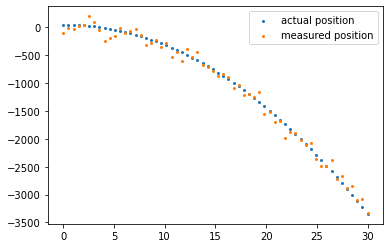

In [570]:
time = np.linspace(0, duration, int(duration / h))
actual_position = actual_state[:, 0, 0]

labels = ['actual position', 'measured position']

plt.scatter(time, actual_position, s = 4)
plt.scatter(time, measured_position, s = 4)

plt.legend(labels)
plt.show()

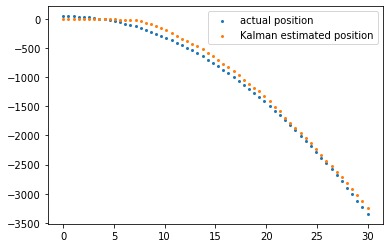

In [571]:
time = np.linspace(0, duration, int(duration / h))
actual_position = actual_state[:, 0, 0]
estimated_position = estimated_state[:, 0, 0]

labels = ['actual position', 'Kalman estimated position']

plt.scatter(time, actual_position, s = 4)
plt.scatter(time, estimated_position, s = 4)

plt.legend(labels)
plt.show()

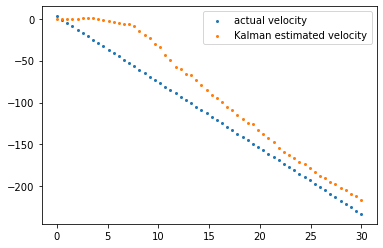

In [572]:
time = np.linspace(0, duration, int(duration / h))
actual_velocity = actual_state[:, 1, 0]
estimated_velocity = estimated_state[:, 1, 0]

labels = ['actual velocity', 'Kalman estimated velocity']

plt.scatter(time, actual_velocity, s = 4)
plt.scatter(time, estimated_velocity, s = 4)

plt.legend(labels)
plt.show()

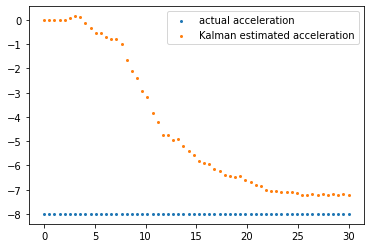

In [573]:
time = np.linspace(0, duration, int(duration / h))
actual_acceleration = actual_state[:, 2, 0]
estimated_acceleration = estimated_state[:, 2, 0]

labels = ['actual acceleration', 'Kalman estimated acceleration']

plt.scatter(time, actual_acceleration, s = 4)
plt.scatter(time, estimated_acceleration, s = 4)

plt.legend(labels)
plt.show()